In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import os
import re
import glob

In [2]:
all_files = glob.glob('C:/Users/lzoeckler/Desktop/all_data/separated/binned/*.csv')
big_df = []
for file in all_files:
    df = pd.read_csv(file)
    big_df.append(df)
big_df = pd.concat(big_df, sort=True)
big_df = big_df.loc[~big_df['PCR_pos'].isnull()]
big_df.head()

,HRP2_deletion,PCR_pos,age_yrs,coinfection,country,febrile,infection_category,lat,long,microscopy_pos,...,quansys_LDH_Pf_result,quansys_LDH_Pv_bin,quansys_LDH_Pv_pg_ml,quansys_LDH_Pv_result,quansys_type,sample_id,sample_type,study_id,survey,timepoint_days
0,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 110501023 (),WB,16-SMRU-01,cross sectional ...,NaN
1,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421001 (),WB,16-SMRU-01,cross sectional ...,NaN
2,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421035 (),WB,16-SMRU-01,cross sectional ...,NaN
3,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 151019 (),WB,16-SMRU-01,cross sectional ...,NaN
4,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1771028 (),WB,16-SMRU-01,cross sectional ...,NaN


In [3]:
def clean_strings(val):
    if isinstance(val, str):
        if '<' in val:
            return np.log10(.1)
        elif '>' in val:
            clean = val.replace('> ', '')
            return np.log10(float(clean) + .1)
        else:
            try:
                return np.log10(float(val) + .1)
            except ValueError:
                return np.null
    elif isinstance(val, float) or isinstance(val, int):
        return np.log10(val + .1)
    else:
        raise

In [4]:
val_cols = ['quansys_HRP2_pg_ml', 'quansys_LDH_Pan_pg_ml', 'quansys_LDH_Pv_pg_ml',
            'quansys_LDH_Pf_pg_ml', 'quansys_CRP_ng_ml']

In [5]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
pos_df = pos_df.loc[~pos_df['quansys_LDH_Pv_pg_ml'].isnull()]
pos_df = pos_df.loc[~pos_df['quansys_HRP2_pg_ml'].isnull()]
pos_df[val_cols] = pos_df[val_cols].applymap(clean_strings)

In [6]:
feb_df = pos_df.copy(deep=True)
feb_df = feb_df.loc[feb_df['febrile'] == 1]
feb_pf_df = feb_df.loc[feb_df['pf'] == 1]
feb_pv_df = feb_df.loc[feb_df['pv'] == 1]
feb_pf_df = feb_pf_df[val_cols + ['PCR_pos', 'sample_id']]
feb_pv_df = feb_pv_df[val_cols + ['PCR_pos', 'sample_id']]
feb_df = feb_df[val_cols + ['PCR_pos', 'sample_id']]

In [7]:
non_feb_df = pos_df.copy(deep=True)
non_feb_df = non_feb_df.loc[non_feb_df['febrile'] == 0]
non_feb_pf_df = non_feb_df.loc[non_feb_df['pf'] == 1]
non_feb_pv_df = non_feb_df.loc[non_feb_df['pv'] == 1]
non_feb_pf_df = non_feb_pf_df[val_cols + ['PCR_pos', 'sample_id']]
non_feb_pv_df = non_feb_pv_df[val_cols + ['PCR_pos', 'sample_id']]
non_feb_df = non_feb_df[val_cols + ['PCR_pos', 'sample_id']]

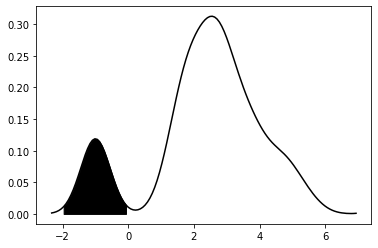

In [12]:
x = non_feb_df['quansys_LDH_Pan_pg_ml'].values
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(0 > x1) & (x1 > -2), color='k')
plt.show()
plt.close()

ValueError: operands could not be broadcast together with shapes (210,) (128,) 

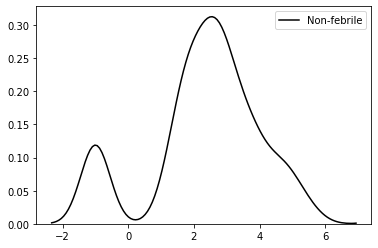

In [13]:
for feb_df, non_feb_df, species in [(feb_pf_df, non_feb_pf_df, 'Pf'), (feb_pv_df, non_feb_pv_df, 'Pv')]:
    x1 = feb_df['quansys_LDH_Pan_pg_ml'].values
    x2 = non_feb_df['quansys_LDH_Pan_pg_ml'].values
    ax = sns.distplot(x2, hist=False, color='k', label='Non-febrile')
    lns = ax.lines
    ln = ax.lines[0]
    y = ln.get_ydata()
    x2a = ln.get_xdata()
    ax.fill_between(x2, 0, y, where=(1 > x2) & (x2 > 0), color='purple')
    plt.show()
    plt.close()

In [37]:
len(x2)

210

In [38]:
len(y)

128